In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


# Data

### preprocces method


In [3]:
def process_data(file_path, per_cluster=500):
    # Read the data
    data = pd.read_csv(file_path, header=None)
    
    if per_cluster:
        # Filter the data to keep only the specified number of entries per cluster
        filtered_data = data.groupby(0).apply(lambda x: x.head(per_cluster)).reset_index(drop=True)
    else:
        # If per_cluster is not specified, use all the data
        filtered_data = data
    
    # Extract feature columns and true labels
    X = filtered_data.iloc[:, 3:].values  # Feature columns
    true_labels = filtered_data.iloc[:, 0].values  # True labels (BLOCK ID)
    
    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, true_labels

In [4]:
#random data
def random_data_load(dvide_amount = 10):
    full_data = pd.read_csv('bio_train.csv')

    # We will consider all rows this time, without filtering by groups
    # Setting the first column as labels and the rest as features
    full_true_labels = full_data.iloc[:, 0].values  # True labels
    full_X = full_data.iloc[:, 1:].values  # Feature columns

    # Normalize the full features
    full_scaler = StandardScaler()
    full_X_scaled = full_scaler.fit_transform(full_X)



    X = full_X_scaled
    X_scaled = full_X_scaled
    true_labels = full_true_labels

    # shuffle and select 10% of the data, however keep x and y together
    np.random.seed(0)
    shuffle = np.random.permutation(len(X))
    X = X[shuffle]
    true_labels = true_labels[shuffle]

    # use 5% of the data
    X = X[:len(X) // dvide_amount]
    true_labels = true_labels[:len(true_labels) // dvide_amount]

    X_scaled = X


    return X_scaled, true_labels

In [5]:
X_scaled, true_labels = random_data_load(10)
X, true_labels = random_data_load(10)

# Clustring routine

In [100]:
def perform_clustering(X, k, max_iters, num_loops, clustering_function, **kwargs):
    all_labels = []
    all_centroids = []
    all_nmi_scores = []
    all_runtimes = []
    all_distance_calculations = []
    all_inertia_histories = []
    all_num_iterations = []

    for i in range(num_loops):
        # Ensure max_iters is passed correctly as a keyword argument
        centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = clustering_function(
            X, k, max_iters, **kwargs
        )
        nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
        
        # Append results to lists
        all_num_iterations.append(num_iterations)
        all_labels.append(labels)
        all_centroids.append(centroids)
        all_nmi_scores.append(nmi_score)
        all_runtimes.append(runtime)
        all_distance_calculations.append(distance_calculations)
        all_inertia_histories.append(inertia_history)

    return {
        'centroids': all_centroids,
        'labels': all_labels,
        'num_iterations': all_num_iterations,
        'inertia_histories': all_inertia_histories,
        'distance_calculations': all_distance_calculations,
        'runtimes': all_runtimes,
        'nmi_scores': all_nmi_scores
    }


# Visualization

In [101]:
def visualize_clustering_results(results):
    # Extract the results
    all_inertia_histories = results['inertia_histories']
    all_nmi_scores = results['nmi_scores']
    all_runtimes = results['runtimes']
    all_distance_calculations = results['distance_calculations']
    
    # Define a list of colors for the bars
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'grey']
    
    def plot_line(data, title, xlabel, ylabel, yscale='linear'):
        plt.figure(figsize=(10, 8))
        if isinstance(data[0], list):
            for i, history in enumerate(data):
                plt.plot(history, label=f'Run {i+1}')
            plt.legend()
        else:
            plt.plot(data, label='Run 1')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.yscale(yscale)
        plt.grid(True)
        plt.show()

    def plot_bar(data, avg, title, xlabel, ylabel):
        plt.figure(figsize=(10, 6))
        if isinstance(data, list):
            bar_data = data + [avg]
            xticks_labels = [f'Run {i}' for i in range(1, len(data)+1)] + ['Average']
        else:
            bar_data = [data, avg]
            xticks_labels = ['Run 1', 'Average']
        
        plt.bar(range(1, len(bar_data) + 1), bar_data, color=colors[:len(bar_data)], alpha=0.7)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xticks(range(1, len(bar_data) + 1), labels=xticks_labels)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()
    
    # Plot the inertia histories
    plot_line(all_inertia_histories, 'K-means Convergence', 'Iteration', 'Inertia', yscale='log')
    
    # Plot the runtimes
    average_runtime = np.mean(all_runtimes) if isinstance(all_runtimes, list) else all_runtimes
    plot_bar(all_runtimes, average_runtime, 'Runtimes for Each Run and Average Runtime', 'Run Number', 'Runtime (seconds)')
    
    # Plot the distance calculations
    average_distance_calculations = np.mean(all_distance_calculations) if isinstance(all_distance_calculations, list) else all_distance_calculations
    plot_bar(all_distance_calculations, average_distance_calculations, 'Distance Calculations for Each Run and Average', 'Run Number', 'Number of Distance Calculations')
    
    # Calculate and print average NMI score
    average_nmi = np.mean(all_nmi_scores) if isinstance(all_nmi_scores, list) else all_nmi_scores
    print(f"Average NMI Score: {average_nmi:.4f}")
    

#  Lloyd’s algorithm for k-Means Clustering 

In [102]:
# Custom K-means and related functions
def initialize_centroids(X, k):
    """Randomly initialize centroids from the data points X."""
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    """Assign data points to the nearest centroid using batch processing."""
    n_samples = X.shape[0]
    batch_size = 100  # Adjust batch size based on available memory
    labels = np.empty(n_samples, dtype=int)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        distances = np.sqrt(((X[start_idx:end_idx] - centroids[:, np.newaxis])**2).sum(axis=2))
        labels[start_idx:end_idx] = np.argmin(distances, axis=0)
    
    return labels


def update_centroids(X, labels, k):
    """Update centroids as the mean of assigned data points."""
    new_centroids = np.empty((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(axis=0)
        else:
            # If cluster has no assigned points, randomly reinitialize the centroid
            new_centroids[i] = X[np.random.choice(X.shape[0])]
    return new_centroids


def kmeans(X, k, max_iters=5000):
    centroids = initialize_centroids(X, k)
    inertia_history = []
    total_distance_calculations = 0
    start_time = time.time()  # Start timing

    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        total_distance_calculations += X.shape[0] * k  # Each assign_clusters call
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time  # End timing
    return centroids, labels, i + 1, inertia_history, total_distance_calculations, runtime

In [103]:
results_k_means = perform_clustering(X_scaled, 153, 10, 1, kmeans)

K-means Iteration: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


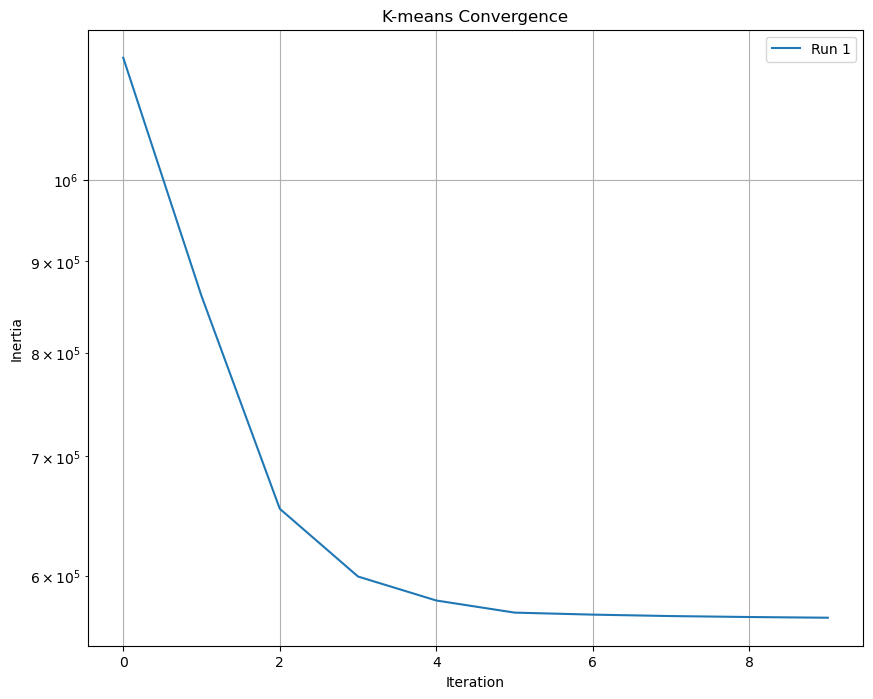

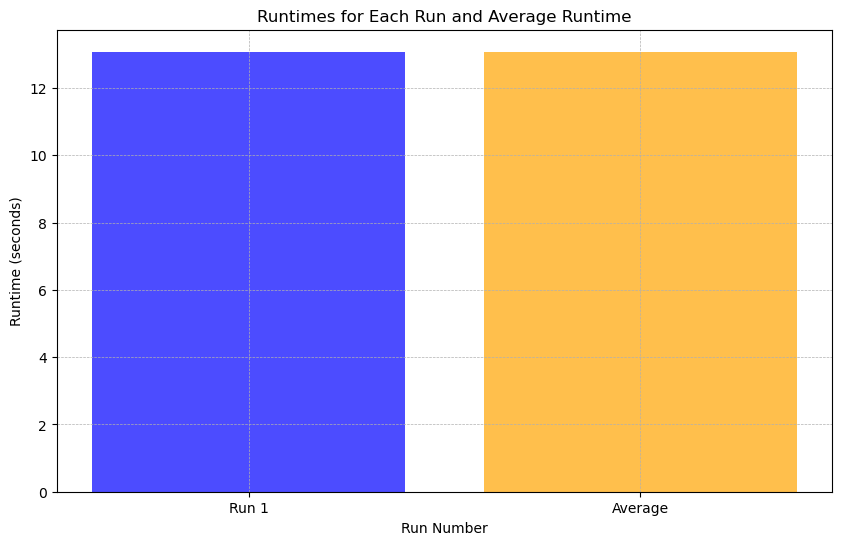

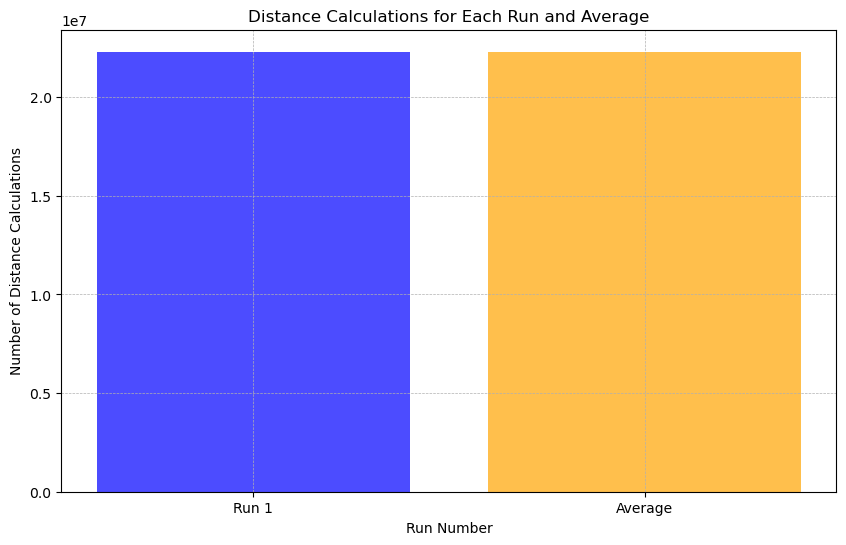

Average NMI Score: 0.2753


In [104]:
visualize_clustering_results(results_k_means)

# k-Means with Locality Sensitive Hashing (LSH)

We have implemented the lsh_has_function as given in the assignement.   
The hash function $h_{a,b}(p): \mathbb{R}^d \rightarrow \mathbb{N}$ maps a point $p \in \mathbb{R}^d$ to a natural number, defined as:   
$ h_{a,b}(p) = \left\lfloor \frac{{\mathbf{a \cdot p} + b}}{{w}} \right\rfloor $

Where:
- $a$ is a random vector in $\mathbb{R}^d$,
- $b$ is a scalar parameter in the range $[0, w]$,
- $w$ is a scalar parameter determining the width of the hash bins,
- $\mathbf{a \cdot p}$ denotes the dot product between vectors $a$ and $p$.

This is done in lsh_hash_function, so first we initialize the lsh with initialize_lsh, where we create a number of a and b vectors according to the number of hash funcs we want. Then we compute the hash signitatur for every point with compute_lsh_hashes

## helper functions

In [105]:
import numpy as np
import time
import random
from collections import defaultdict
from tqdm import tqdm

# Define a function to compute the Euclidean distance
def euclidean_distance(point, centroids):
    return np.sqrt(np.sum((centroids - point) ** 2, axis=1))

# Define the LSH hash function as a standalone function
def lsh_hash_function(X, a, b, w):
    projection = X.dot(a)
    shifted_projection = projection + b
    normalized_value = shifted_projection / w
    bin_index = np.floor(normalized_value)
    return bin_index

# Initialize LSH parameters and create a list of hash functions
def initialize_lsh(X, n, m, w):
    num_data_points, d = X.shape
    a = np.random.randn(n * m, d)
    b = np.random.uniform(0, w, n * m)
    return a, b, w

# Compute hash values for all data points
def compute_lsh_hashes(X, a, b, w):
    num_hashes = len(a)
    hashes = np.column_stack([lsh_hash_function(X, a[i], b[i], w) for i in range(num_hashes)])
    return hashes

def assign_to_buckets(hashes):
    bucket_dict = {}
    for index, hash_values in enumerate(hashes):
        hash_tuple = tuple(hash_values)
        if hash_tuple in bucket_dict:
            bucket_dict[hash_tuple].append(index)
        else:
            bucket_dict[hash_tuple] = [index]
    return bucket_dict

def create_centroid_slice_map(centroids, a, b, w, n, m):
    centroid_slice_map = defaultdict(list)
    centroid_hashes = compute_lsh_hashes(centroids, a, b, w)
    for i, hash_val in enumerate(centroid_hashes):
        for j in range(n):
            slice_key = (j, tuple(hash_val[j * m:(j + 1) * m]))
            centroid_slice_map[slice_key].append(i)
    return centroid_slice_map

def assign_points_to_centroids(point_hash_buckets, centroid_slice_map, centroids, n, m):
    centroid_point_map = defaultdict(list)
    for key in list(point_hash_buckets.keys()):
        for i in range(n):
            slice_key = (i, tuple(key[i * m:(i + 1) * m]))
            if slice_key in centroid_slice_map:
                matching_centroid_idx = random.choice(centroid_slice_map[slice_key])
                centroid = centroids[matching_centroid_idx]
                centroid_point_map[tuple(centroid)].extend(point_hash_buckets.pop(key))
                break
    return centroid_point_map

def initialize_clusters(X, k):
    #np.random.seed(42)
    initial_indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[initial_indices]
    return centroids


For the k- means our two most important algorithms are First, the number of data points in X is determined and stored in n_samples. An array labels is initialized to store the cluster assignment for each data point. The hash values for each centroid are computed and stored in centroid_hashes. An empty list hash_groups is initialized to store groups of hash functions, and a list bucket_random_points is initialized to store random points from each bucket (cluster).

Next, a loop runs n times to create n groups of m hash functions. For each group, the start and end indices for the current group of hash functions are determined, and the group of m hash functions is added to hash_groups.

Then, the function iterates over each point i in X. For each point, potential_centroids is initialized to track centroids that match the hash values. The function then checks each group of hash functions to see if all hashes in the group match between the point and the centroids. If a match is found, potential_centroids is updated with the matching results.

If any potential centroid matches are found, the distances from the point to all potential centroids are computed, and the point is assigned to the closest centroid. If no matches are found, a random point is selected, distances to all centroids are computed, and the point is assigned to the closest centroid. The point is then stored in bucket_random_points for its assigned centroid.

Finally, the function returns labels (cluster assignments) and bucket_random_points (random points from each bucket).

## main loop

In [106]:
def kmeans_lsh(X, k, max_iters=500, n=10, m=30, w=4.0):
    start_time = time.time()
    
    a, b, w = initialize_lsh(X, n, m, w)
    hashes = compute_lsh_hashes(X, a, b, w)
    point_hash_buckets = assign_to_buckets(hashes)
    
    centroids = initialize_clusters(X, k)
    inertia_history = []
    total_distance_calculations = 0
    
    for iteration in tqdm(range(max_iters), desc="K-means Iteration"):
        # Create the centroid slice map
        centroid_slice_map = create_centroid_slice_map(centroids, a, b, w, n, m)
        
        # Assign points to centroids using LSH
        centroid_buckets = assign_points_to_centroids(point_hash_buckets, centroid_slice_map, centroids, n, m)
        
        # Assign remaining points in point_hash_buckets to the nearest centroid
        for remaining_points in point_hash_buckets.values():
            random_point_index = random.choice(remaining_points)
            random_point = X[random_point_index]
            distances = euclidean_distance(random_point, centroids)
            nearest_centroid_index = np.argmin(distances)
            centroid_buckets[tuple(centroids[nearest_centroid_index])].extend(remaining_points)
        
        # Update centroids
        new_centroids = np.zeros_like(centroids)
        labels = np.full(len(X), -1)
        for i, centroid in enumerate(centroids):
            points_indices = centroid_buckets[tuple(centroid)]
            if points_indices:
                new_centroids[i] = np.mean(X[points_indices], axis=0)
                labels[points_indices] = i
        
        # Compute inertia
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        
        # Count distance calculations
        total_distance_calculations += X.shape[0] * k
        
        # Check for convergence
        if np.allclose(new_centroids, centroids):
            break
        
        centroids = new_centroids
        point_hash_buckets = assign_to_buckets(hashes)
    
    runtime = time.time() - start_time  # End timing
    
    return centroids, labels, iteration + 1, inertia_history, total_distance_calculations, runtime

In [107]:
results_k_means_lsh = perform_clustering(
    X_scaled, 
    153, 
    50, 
    1, 
    kmeans_lsh
)


K-means Iteration: 100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


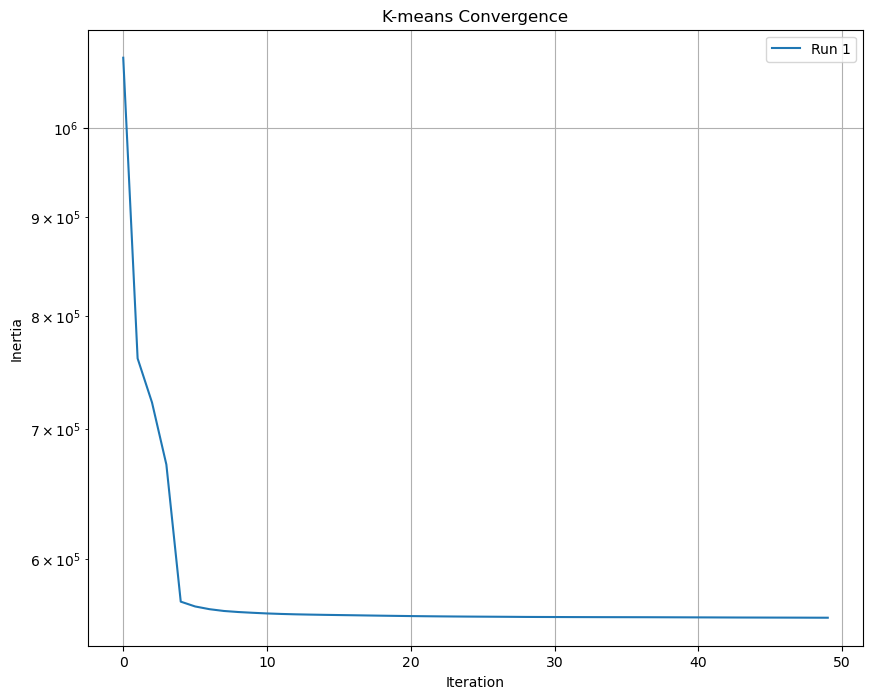

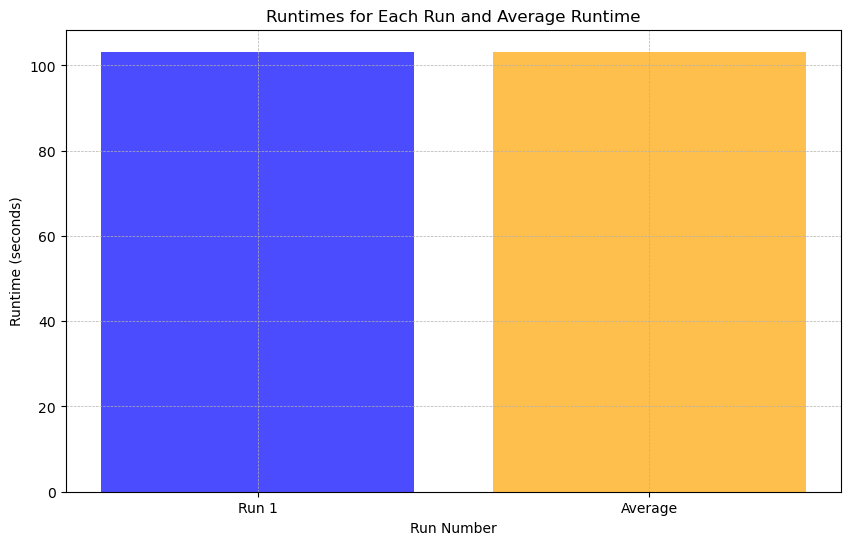

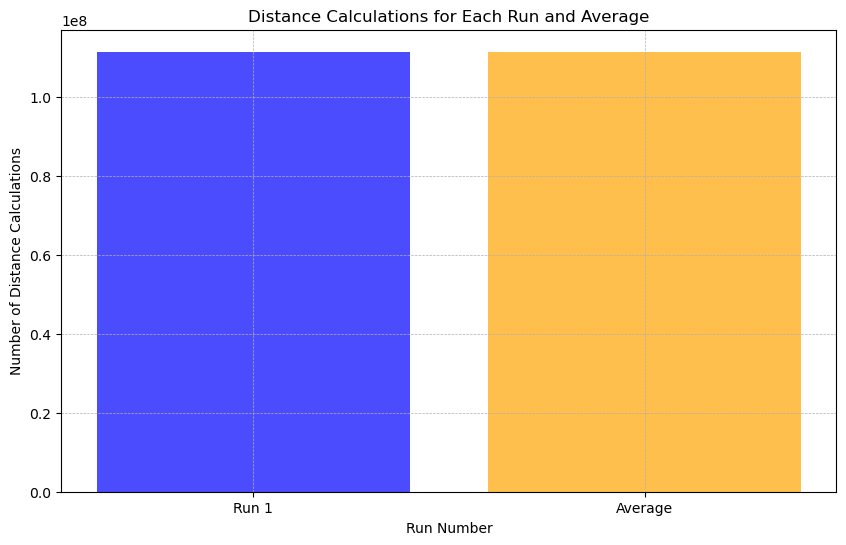

Average NMI Score: 0.2742


In [108]:
visualize_clustering_results(results_k_means_lsh)

In [109]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.datasets import make_blobs

def lightweight_coreset(X, k, m):
    n = X.shape[0]
    if n < m:
        print(f"Warning: The dataset size ({n}) is smaller than the coreset size ({m}). Consider allowing replacement or reducing the coreset size.")
        return X, np.ones(n) / n, np.arange(n)
    mu = np.mean(X, axis=0)
    dists_sq = np.sum((X - mu) ** 2, axis=1)
    total_dist_sq = np.sum(dists_sq)
    
    q = 0.5 / X.shape[0] + 0.5 * dists_sq / total_dist_sq
    indices = np.random.choice(X.shape[0], size=m, replace=False, p=q / q.sum())
    weights = 1 / (m * q[indices])
    
    return X[indices], weights, indices

def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    return labels, distances.min(axis=1).sum()

def update_centroids(X, labels, k, weights):
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))
    for i in range(k):
        cluster_indices = labels == i
        if np.sum(weights[cluster_indices]) > 0:
            weighted_points = X[cluster_indices] * weights[cluster_indices, np.newaxis]
            centroids[i] = weighted_points.sum(axis=0) / weights[cluster_indices].sum()
        else:
            centroids[i] = X[np.random.choice(X.shape[0])]
    return centroids

def kmeans_coreset(X, k, coreset_size, max_iters=100):
    start_time = time.time()
    if coreset_size < k:
        print(f"Coreset size {coreset_size} must be at least as large as k {k}, therefore k is now coreset size")
        k = coreset_size
    
    coreset, weights, indices = lightweight_coreset(X, k, coreset_size)
    centroids = initialize_centroids(coreset, k)
    inertia_history = []
    total_distance_calculations = 0
    
    for i in range(max_iters):
        labels, inertia = assign_clusters(coreset, centroids)
        inertia_history.append(inertia)
        new_centroids = update_centroids(coreset, labels, k, weights)
        total_distance_calculations += coreset.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    full_labels = assign_clusters(X, centroids)[0]
    return centroids, full_labels, i+1, inertia_history, total_distance_calculations, runtime, indices

# Generate synthetic dataset
np.random.seed(42)
X, true_labels = make_blobs(n_samples=1000, centers=5, cluster_std=0.60, random_state=42)

k = 5
max_iters = 50
coreset_sizes = [50, 100, 200, 500]
num_runs = 10

# Lists to store results
results = {m: {"nmi_scores": [], "runtimes": [], "distance_calculations": [], "num_iterations": [], "indices": []} for m in coreset_sizes}

for m in tqdm(coreset_sizes, desc="Coreset Sizes"):
    for _ in range(num_runs):
        centroids, labels, num_iterations, inertia_history, distance_calculations, runtime, indices = kmeans_coreset(X, k, m, max_iters)
        nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')

        # Append results to lists
        results[m]["nmi_scores"].append(nmi_score)
        results[m]['inertia_histories'].append(inertia_history)
        results[m]["runtimes"].append(runtime)
        results[m]["distance_calculations"].append(distance_calculations)
        results[m]["num_iterations"].append(num_iterations)
        results[m]["indices"].append(indices)

# Plot the original data and one instance of coreset points
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.title('Original Data')
plt.xlabel('X')
plt.ylabel('Y')

for i, m in enumerate([100, 500]):
    plt.subplot(1, 3, i+2)
    plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', alpha=0.3, edgecolors='k')
    coreset_indices = results[m]["indices"][0]
    plt.scatter(X[coreset_indices, 0], X[coreset_indices, 1], c='red', s=100, alpha=1, edgecolors='k', marker='x', label='Coreset Points')
    plt.title(f'Coreset (m = {m})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

plt.tight_layout()
plt.savefig('coreset_visualization.png')

# Analyze and visualize the variance of accuracy
plt.figure(figsize=(10, 5))

# Box plot for NMI scores
plt.subplot(1, 2, 1)
nmi_scores = [results[m]["nmi_scores"] for m in coreset_sizes]
plt.boxplot(nmi_scores, labels=[str(m) for m in coreset_sizes])
plt.title('NMI Scores Variance')
plt.xlabel('Coreset Size (m)')
plt.ylabel('NMI Score')

# Line plot for mean and std of NMI scores
plt.subplot(1, 2, 2)
means = [np.mean(results[m]["nmi_scores"]) for m in coreset_sizes]
stds = [np.std(results[m]["nmi_scores"]) for m in coreset_sizes]

plt.errorbar(coreset_sizes, means, yerr=stds, fmt='-o', capsize=5)
plt.title('Mean NMI Score with Standard Deviation')
plt.xlabel('Coreset Size (m)')
plt.ylabel('NMI Score')
plt.xscale('log')

plt.tight_layout()
plt.savefig('nmi_variance_analysis.png')

# Print statistics
print("\nStatistics:")
for m in coreset_sizes:
    nmi_scores = results[m]["nmi_scores"]
    print(f"Coreset Size {m}:")
    print(f"  Mean NMI Score: {np.mean(nmi_scores):.4f}")
    print(f"  Std NMI Score: {np.std(nmi_scores):.4f}")
    print(f"  Min NMI Score: {np.min(nmi_scores):.4f}")
    print(f"  Max NMI Score: {np.max(nmi_scores):.4f}\n")

Coreset Sizes:   0%|          | 0/4 [00:00<?, ?it/s]


KeyError: 'inertia_histories'

In [110]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def lightweight_coreset(X, k, m):
    n = X.shape[0]
    if n < m:
        print(f"Warning: The dataset size ({n}) is smaller than the coreset size ({m}). Consider allowing replacement or reducing the coreset size.")
        return X, np.ones(n) / n, np.arange(n)
    # Compute the mean of the data
    mu = np.mean(X, axis=0)
    # Compute distances from the mean
    dists_sq = np.sum((X - mu) ** 2, axis=1)
    total_dist_sq = np.sum(dists_sq)
    
    # Probability distribution for importance sampling
    q = 0.5 / X.shape[0] + 0.5 * dists_sq / total_dist_sq
    # Sampling according to q
    indices = np.random.choice(X.shape[0], size=m, replace=False, p=q / q.sum())
    # Compute weights inversely proportional to q
    weights = 1 / (m * q[indices])
    
    return X[indices], weights, indices

def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    return labels, distances.min(axis=1).sum()

def update_centroids(X, labels, k, weights):
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))
    for i in range(k):
        cluster_indices = labels == i
        if np.sum(weights[cluster_indices]) > 0:
            weighted_points = X[cluster_indices] * weights[cluster_indices, np.newaxis]
            centroids[i] = weighted_points.sum(axis=0) / weights[cluster_indices].sum()
        else:
            centroids[i] = X[np.random.choice(X.shape[0])]
    return centroids

def kmeans_coreset(X, k, coreset_size,m,max_iters=100):
    start_time = time.time()
    if coreset_size < k:
        print(f"Coreset size {coreset_size} must be at least as large as k {k}, therefore k is now coreset size")
        k = coreset_size
    if m < coreset_size or m < k:
        print("amount of samples in total must be at least the number of clusters/coreset size")
        if coreset_size < k:
            m = k
        else:
            m = coreset_size
            
    # cut the examples 
    local_X = X[:m]
    
    # Step 1: Sample the lightweight coreset
    coreset, weights, indices = lightweight_coreset(local_X, k, coreset_size)
    
    variance_list = [np.var(point) for point in coreset]

    
 
    
    # Step 2: Run K-means on the coreset
    centroids = initialize_centroids(coreset, k)
    inertia_history = []
    total_distance_calculations = 0
    
    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels, inertia = assign_clusters(coreset, centroids)
        inertia_history.append(inertia)
        new_centroids = update_centroids(coreset, labels, k, weights)
        total_distance_calculations += coreset.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    
    # Step 3: Assign clusters to all points
    full_labels = assign_clusters(X, centroids)[0]
    return centroids, full_labels, i+1, inertia_history, total_distance_calculations, runtime, indices, variance_list

# Example usage with a dummy dataset
if __name__ == "__main__":


    # Example dataset
    point_amount = [100, 1000, 5000, 10000]
    coreset_sizes = [100, 200, 500, 1000, 2000]
    k = 153
    max_iters = 50
    
    # Generating a random dataset for demonstration
    X = np.random.randn(10000, 2)  # Replace with your actual dataset
    true_labels = np.random.randint(0, k, size=10000)  # Replace with your actual labels if available

    # Lists to store results
    results = {m: {"nmi_scores": [], "runtimes": [], "distance_calculations": [], "inertia_histories": [],"var": [], "num_iterations": [], "indices": []} for m in range(len(coreset_sizes)*len(point_amount))}
    idx = 0
    for point in point_amount:  # Running only once for demonstration
        for coreset_size in coreset_sizes:
            centroids, labels, num_iterations, inertia_history, distance_calculations, runtime, indices,variances_list = kmeans_coreset(X, k, coreset_size,point, max_iters)
            nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')

            # Append results to lists
            results[idx]["nmi_scores"].append(nmi_score)
            results[idx]["runtimes"].append(runtime)
            results[idx]['inertia_histories'].append(inertia_history)
            results[idx]["distance_calculations"].append(distance_calculations)
            results[idx]["num_iterations"].append(num_iterations)
            results[idx]["indices"].append(indices)
            results[idx]["var"].append(variances_list)
            idx += 1
    
    # Display results
    for m in results:
        print(f"Coreset size {m} results:")
        print(f"  NMI scores: {results[m]['nmi_scores']}")
        print(f"  Runtimes: {results[m]['runtimes']}")
        print(f"  Distance calculations: {results[m]['distance_calculations']}")
        print(f"  Number of iterations: {results[m]['num_iterations']}")
        # first 10 variances for
        for variance in results[m]['var'][0][:10]:
            print(f"  Variances: {variance}")

Coreset size 100 must be at least as large as k 153, therefore k is now coreset size


K-means Iteration:   2%|▏         | 1/50 [00:00<00:00, 166.64it/s]


amount of samples in total must be at least the number of clusters/coreset size


K-means Iteration:   8%|▊         | 4/50 [00:00<00:00, 131.04it/s]

amount of samples in total must be at least the number of clusters/coreset size



K-means Iteration:   8%|▊         | 4/50 [00:00<00:00, 85.11it/s]


amount of samples in total must be at least the number of clusters/coreset size


K-means Iteration:  22%|██▏       | 11/50 [00:00<00:00, 45.85it/s]


amount of samples in total must be at least the number of clusters/coreset size


K-means Iteration:  28%|██▊       | 14/50 [00:00<00:00, 42.53it/s]


Coreset size 100 must be at least as large as k 153, therefore k is now coreset size


K-means Iteration:  18%|█▊        | 9/50 [00:00<00:00, 98.77it/s]


amount of samples in total must be at least the number of clusters/coreset size


K-means Iteration:  48%|████▊     | 24/50 [00:00<00:00, 67.81it/s]


Coreset size 100 must be at least as large as k 153, therefore k is now coreset size


K-means Iteration:  34%|███▍      | 17/50 [00:00<00:00, 62.68it/s]


Coreset size 100 must be at least as large as k 153, therefore k is now coreset size


K-means Iteration:  28%|██▊       | 14/50 [00:00<00:00, 64.41it/s]

Coreset size 0 results:
  NMI scores: [0.15904497949493557]
  Runtimes: [0.011999130249023438]
  Distance calculations: [20000]
  Number of iterations: [2]
  Variances: 0.043388575311485024
  Variances: 1.3919249214195215
  Variances: 1.2877767667798743
  Variances: 0.27088939798744177
  Variances: 0.007380634633577032
  Variances: 0.006503841533900845
  Variances: 0.00011368317426814384
  Variances: 2.8145769651950867
  Variances: 0.05577528467164727
  Variances: 3.9582847366651808
Coreset size 1 results:
  NMI scores: [0.20730819425930347]
  Runtimes: [0.03952288627624512]
  Distance calculations: [153000]
  Number of iterations: [5]
  Variances: 0.008041777381042338
  Variances: 0.75365372242365
  Variances: 0.3287982932961012
  Variances: 1.1303628838555253
  Variances: 0.21547036210862255
  Variances: 0.03380482664004067
  Variances: 3.170011392376558
  Variances: 0.00011368317426814384
  Variances: 0.05228572087678852
  Variances: 0.6460208638986206
Coreset size 2 results:
  NMI 

Coreset size 100 must be at least as large as k 153, therefore k is now coreset size


K-means Iteration:   2%|▏         | 1/50 [00:00<00:00, 52.39it/s]


Amount of samples in total must be at least the number of clusters/coreset size


K-means Iteration:   6%|▌         | 3/50 [00:00<00:00, 55.51it/s]


Amount of samples in total must be at least the number of clusters/coreset size


K-means Iteration:  16%|█▌        | 8/50 [00:00<00:00, 55.42it/s]


Amount of samples in total must be at least the number of clusters/coreset size


K-means Iteration:  16%|█▌        | 8/50 [00:00<00:00, 49.12it/s]


Amount of samples in total must be at least the number of clusters/coreset size


K-means Iteration:  32%|███▏      | 16/50 [00:00<00:01, 32.15it/s]


Coreset size 100 must be at least as large as k 153, therefore k is now coreset size


K-means Iteration:  16%|█▌        | 8/50 [00:00<00:00, 53.11it/s]


Amount of samples in total must be at least the number of clusters/coreset size


K-means Iteration:  24%|██▍       | 12/50 [00:00<00:01, 34.81it/s]


Coreset size 100 must be at least as large as k 153, therefore k is now coreset size


K-means Iteration:  20%|██        | 10/50 [00:00<00:00, 61.98it/s]


Coreset size 100 must be at least as large as k 153, therefore k is now coreset size


K-means Iteration:  42%|████▏     | 21/50 [00:00<00:00, 60.76it/s]


Config 0 results:
  NMI scores: [0.160824192244966]
  Runtimes: [0.025997400283813477]
  Distance calculations: [20000]
  Number of iterations: [2]
Config 1 results:
  NMI scores: [0.21047761315104743]
  Runtimes: [0.061023712158203125]
  Distance calculations: [122400]
  Number of iterations: [4]
Config 2 results:
  NMI scores: [0.21416155621960942]
  Runtimes: [0.15137362480163574]
  Distance calculations: [688500]
  Number of iterations: [9]
Config 3 results:
  NMI scores: [0.21467159807434733]
  Runtimes: [0.16874170303344727]
  Distance calculations: [1377000]
  Number of iterations: [9]
Config 4 results:
  NMI scores: [0.21751883181786158]
  Runtimes: [0.5026073455810547]
  Distance calculations: [5202000]
  Number of iterations: [17]
Config 5 results:
  NMI scores: [0.15616427043502523]
  Runtimes: [0.015987157821655273]
  Distance calculations: [20000]
  Number of iterations: [2]
Config 6 results:
  NMI scores: [0.21081402190215284]
  Runtimes: [0.028896808624267578]
  Distance

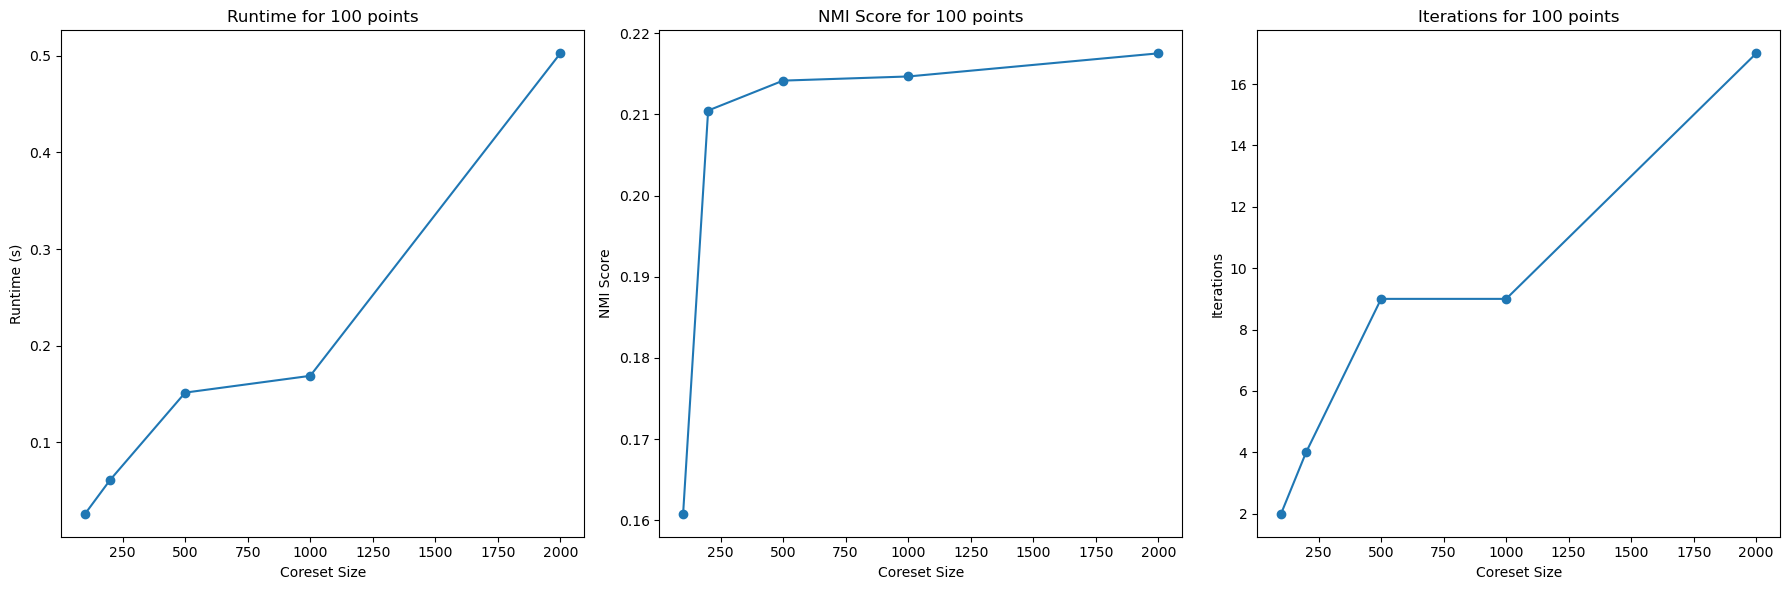

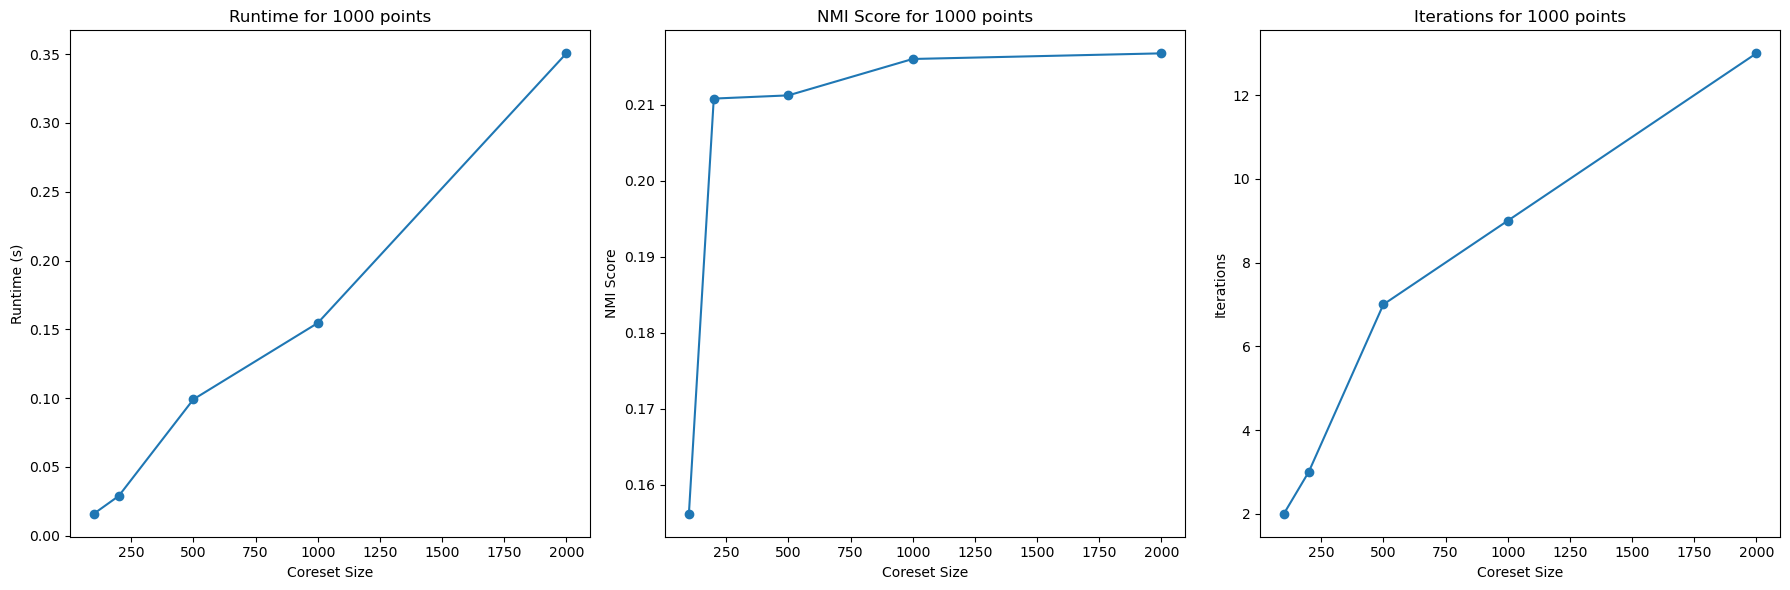

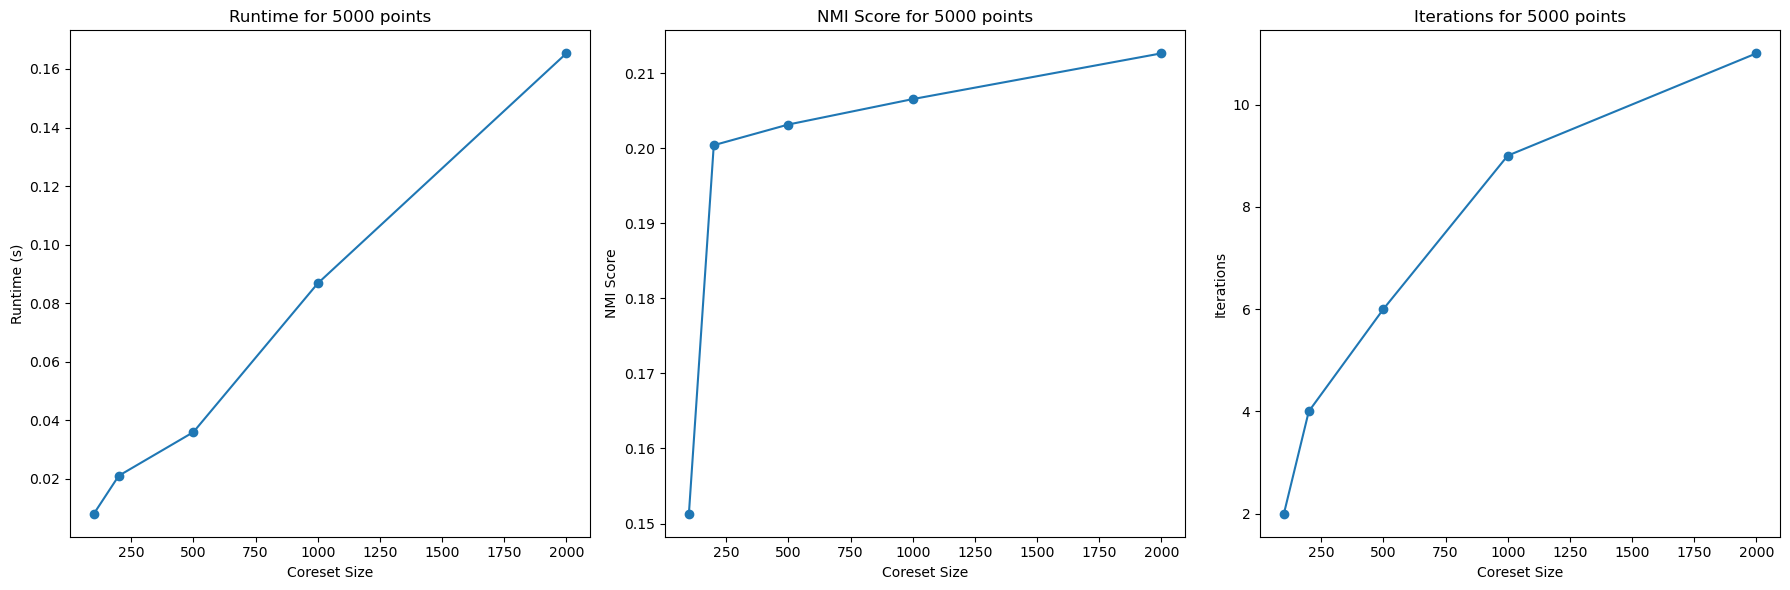

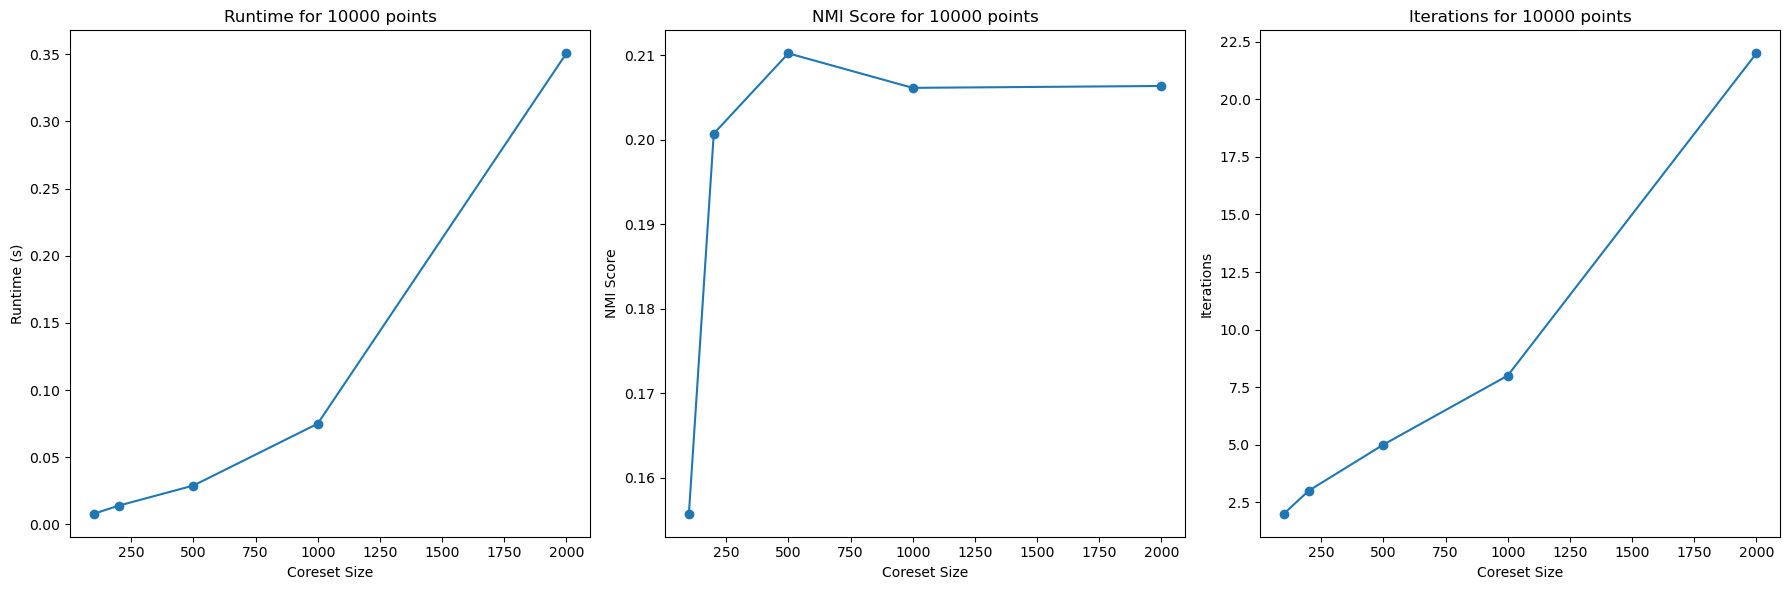

In [112]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def lightweight_coreset(X, k, m):
    n = X.shape[0]
    if n < m:
        print(f"Warning: The dataset size ({n}) is smaller than the coreset size ({m}). Consider allowing replacement or reducing the coreset size.")
        return X, np.ones(n) / n, np.arange(n)
    # Compute the mean of the data
    mu = np.mean(X, axis=0)
    # Compute distances from the mean
    dists_sq = np.sum((X - mu) ** 2, axis=1)
    total_dist_sq = np.sum(dists_sq)
    
    # Probability distribution for importance sampling
    q = 0.5 / X.shape[0] + 0.5 * dists_sq / total_dist_sq
    # Sampling according to q
    indices = np.random.choice(X.shape[0], size=m, replace=False, p=q / q.sum())
    # Compute weights inversely proportional to q
    weights = 1 / (m * q[indices])
    
    return X[indices], weights, indices

def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    return labels, distances.min(axis=1).sum()

def update_centroids(X, labels, k, weights):
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))
    for i in range(k):
        cluster_indices = labels == i
        if np.sum(weights[cluster_indices]) > 0:
            weighted_points = X[cluster_indices] * weights[cluster_indices, np.newaxis]
            centroids[i] = weighted_points.sum(axis=0) / weights[cluster_indices].sum()
        else:
            centroids[i] = X[np.random.choice(X.shape[0])]
    return centroids

def kmeans_coreset(X, k, coreset_size, m, max_iters=100):
    start_time = time.time()
    if coreset_size < k:
        print(f"Coreset size {coreset_size} must be at least as large as k {k}, therefore k is now coreset size")
        k = coreset_size
    if m < coreset_size or m < k:
        print("Amount of samples in total must be at least the number of clusters/coreset size")
        if coreset_size < k:
            m = k
        else:
            m = coreset_size
            
    # Cut the examples
    local_X = X[:m]
    
    # Step 1: Sample the lightweight coreset
    coreset, weights, indices = lightweight_coreset(local_X, k, coreset_size)
    
    # Step 2: Run K-means on the coreset
    centroids = initialize_centroids(coreset, k)
    inertia_history = []
    total_distance_calculations = 0
    
    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels, inertia = assign_clusters(coreset, centroids)
        inertia_history.append(inertia)
        new_centroids = update_centroids(coreset, labels, k, weights)
        total_distance_calculations += coreset.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    
    # Step 3: Assign clusters to all points
    full_labels = assign_clusters(X, centroids)[0]
    return centroids, full_labels, i+1, inertia_history, total_distance_calculations, runtime, indices

# Example usage with a dummy dataset
if __name__ == "__main__":
    # Example dataset
    point_amount = [100, 1000, 5000, 10000]
    coreset_sizes = [100, 200, 500, 1000, 2000]
    k = 153
    max_iters = 50
    


    # Lists to store results
    results = {m: {"nmi_scores": [], "runtimes": [], "distance_calculations": [], "inertia_histories": [], "num_iterations": [], "indices": []} for m in range(len(coreset_sizes)*len(point_amount))}
    idx = 0
    for point in point_amount:
        for coreset_size in coreset_sizes:
            centroids, labels, num_iterations, inertia_history, distance_calculations, runtime, indices = kmeans_coreset(X, k, coreset_size, point, max_iters)
            nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')

            # Append results to lists
            results[idx]["nmi_scores"].append(nmi_score)
            results[idx]["runtimes"].append(runtime)
            results[idx]['inertia_histories'].append(inertia_history)
            results[idx]["distance_calculations"].append(distance_calculations)
            results[idx]["num_iterations"].append(num_iterations)
            results[idx]["indices"].append(indices)
            idx += 1

    # Display results
    for m in results:
        print(f"Config {m} results:")
        print(f"  NMI scores: {results[m]['nmi_scores']}")
        print(f"  Runtimes: {results[m]['runtimes']}")
        print(f"  Distance calculations: {results[m]['distance_calculations']}")
        print(f"  Number of iterations: {results[m]['num_iterations']}")

    # Plot results
    for m in range(len(point_amount)):
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.plot(coreset_sizes, [results[m*len(coreset_sizes)+i]['runtimes'][0] for i in range(len(coreset_sizes))], marker='o')
        plt.title(f'Runtime for {point_amount[m]} points')
        plt.xlabel('Coreset Size')
        plt.ylabel('Runtime (s)')

        plt.subplot(1, 3, 2)
        plt.plot(coreset_sizes, [results[m*len(coreset_sizes)+i]['nmi_scores'][0] for i in range(len(coreset_sizes))], marker='o')
        plt.title(f'NMI Score for {point_amount[m]} points')
        plt.xlabel('Coreset Size')
        plt.ylabel('NMI Score')
        
        plt.subplot(1, 3, 3)
        plt.plot(coreset_sizes, [results[m*len(coreset_sizes)+i]['num_iterations'][0] for i in range(len(coreset_sizes))], marker='o')
        plt.title(f'Iterations for {point_amount[m]} points')
        plt.xlabel('Coreset Size')
        plt.ylabel('Iterations')
        
        plt.tight_layout()
        plt.show()


Coreset size 100 must be at least as large as k 153, therefore k is now coreset size


C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Amount of samples in total must be at least the number of clusters/coreset size


C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Amount of samples in total must be at least the number of clusters/coreset size


C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Amount of samples in total must be at least the number of clusters/coreset size


C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Amount of samples in total must be at least the number of clusters/coreset size


C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Coreset size 100 must be at least as large as k 153, therefore k is now coreset size


C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

Amount of samples in total must be at least the number of clusters/coreset size


C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Coreset size 100 must be at least as large as k 153, therefore k is now coreset size


C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

Coreset size 100 must be at least as large as k 153, therefore k is now coreset size


C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Alexm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

Config 0 results:
  NMI scores: [0.20863933442192556]
  Runtimes: [1.2168948650360107]
  Distance calculations: [500000]
  Number of iterations: [1]
Config 1 results:
  NMI scores: [0.22192602726571536]
  Runtimes: [0.4269423484802246]
  Distance calculations: [1530000]
  Number of iterations: [2]
Config 2 results:
  NMI scores: [0.2235663368564139]
  Runtimes: [0.23715519905090332]
  Distance calculations: [3825000]
  Number of iterations: [5]
Config 3 results:
  NMI scores: [0.2431456804069123]
  Runtimes: [0.3682591915130615]
  Distance calculations: [7650000]
  Number of iterations: [9]
Config 4 results:
  NMI scores: [0.2504390672430072]
  Runtimes: [0.5343129634857178]
  Distance calculations: [15300000]
  Number of iterations: [17]
Config 5 results:
  NMI scores: [0.20254212741952732]
  Runtimes: [0.13492321968078613]
  Distance calculations: [500000]
  Number of iterations: [1]
Config 6 results:
  NMI scores: [0.21949248203262578]
  Runtimes: [0.38604044914245605]
  Distance ca

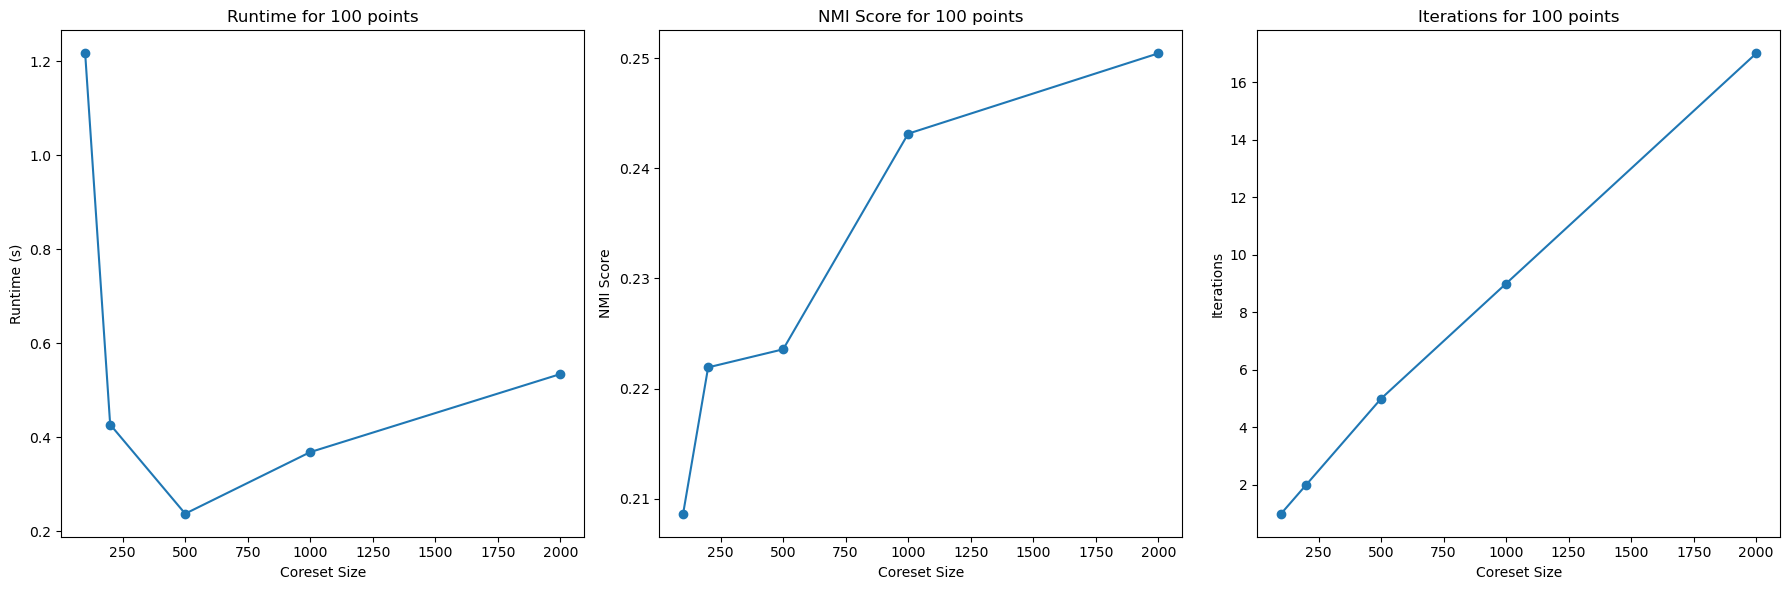

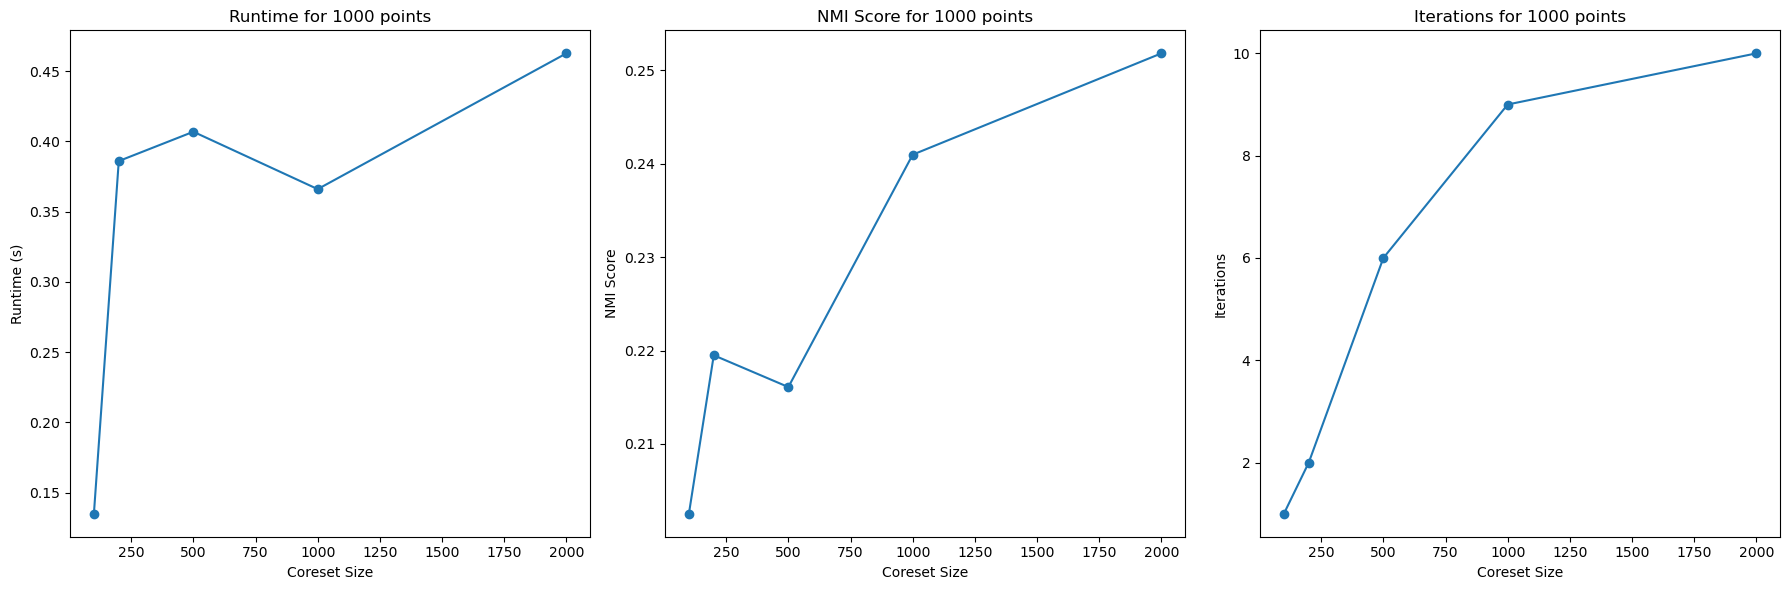

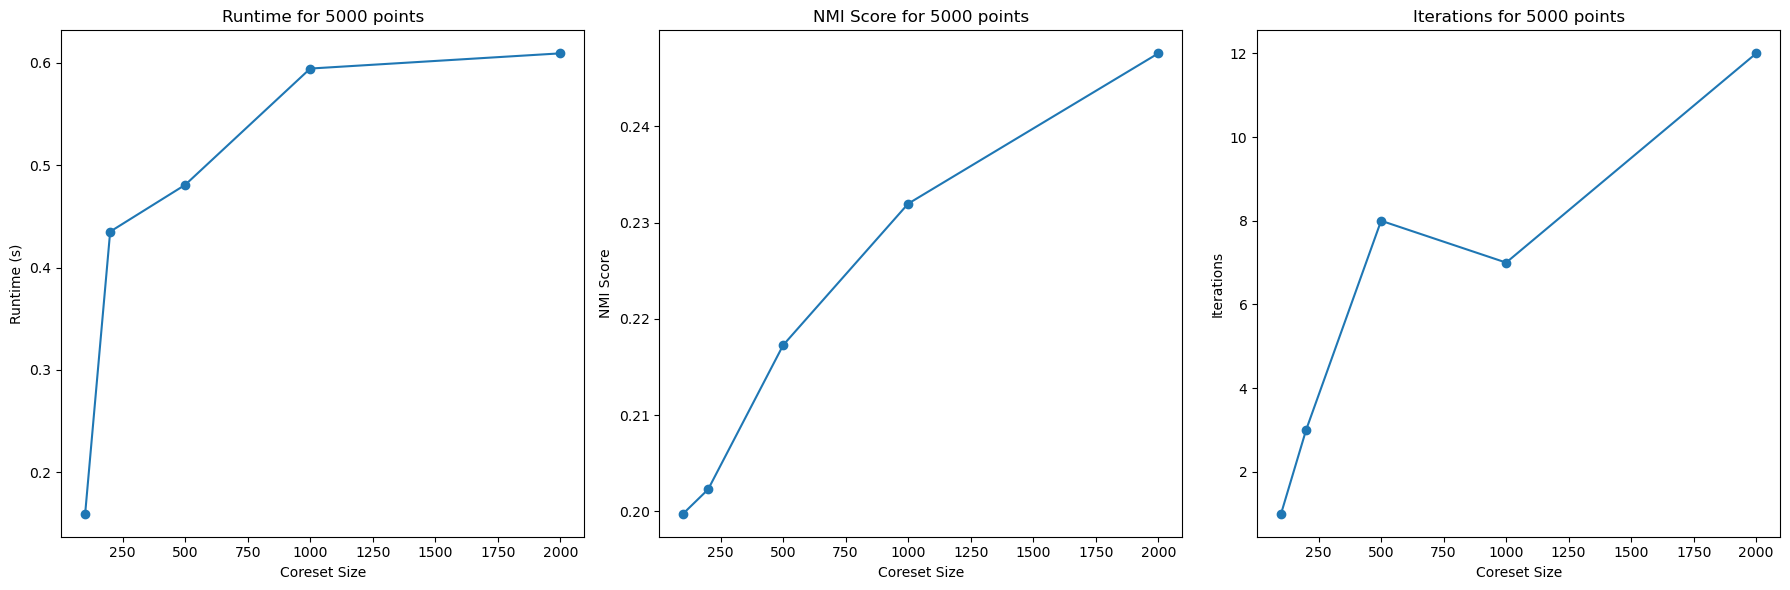

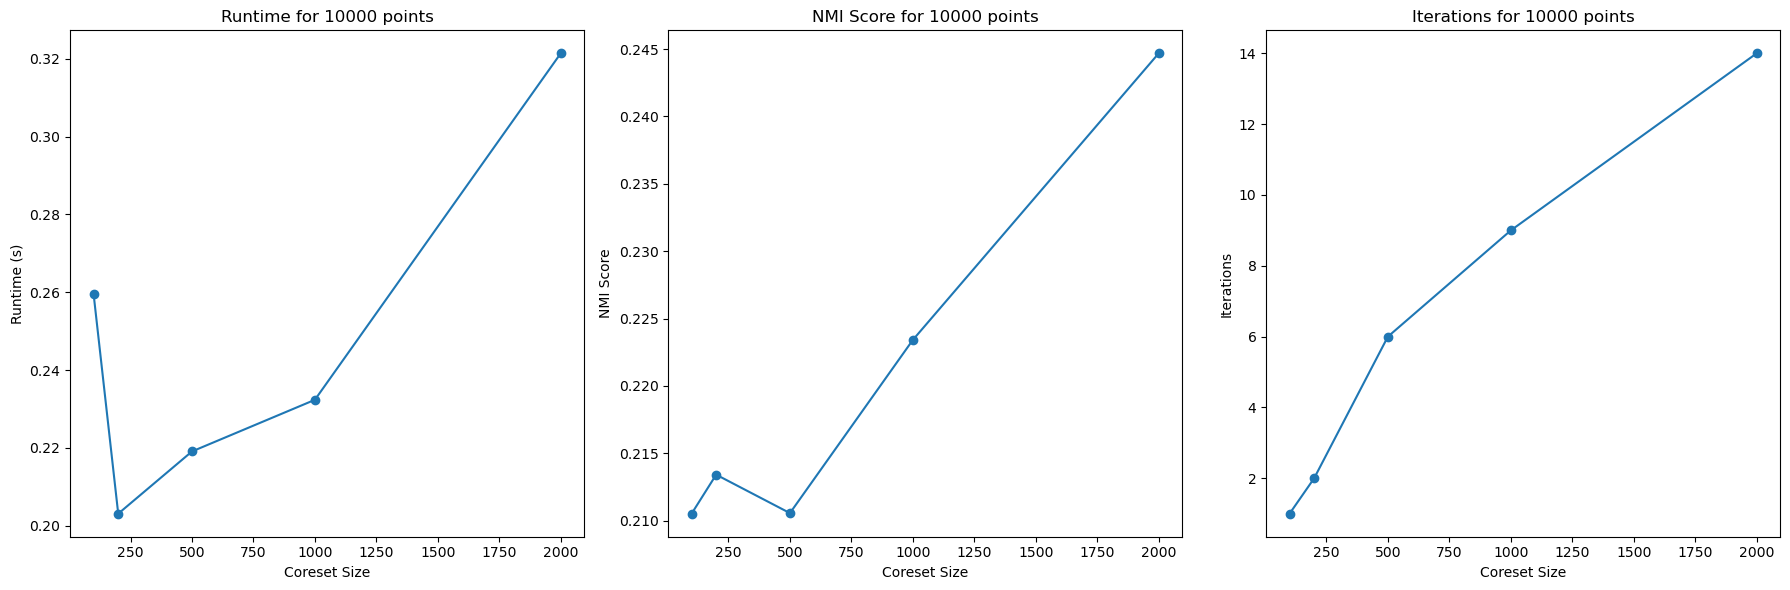

In [6]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def lightweight_coreset(X, k, m):
    n = X.shape[0]
    if n < m:
        print(f"Warning: The dataset size ({n}) is smaller than the coreset size ({m}). Consider allowing replacement or reducing the coreset size.")
        return X, np.ones(n) / n, np.arange(n)
    # Compute the mean of the data
    mu = np.mean(X, axis=0)
    # Compute distances from the mean
    dists_sq = np.sum((X - mu) ** 2, axis=1)
    total_dist_sq = np.sum(dists_sq)
    
    # Probability distribution for importance sampling
    q = 0.5 / X.shape[0] + 0.5 * dists_sq / total_dist_sq
    # Sampling according to q
    indices = np.random.choice(X.shape[0], size=m, replace=False, p=q / q.sum())
    # Compute weights inversely proportional to q
    weights = 1 / (m * q[indices])
    
    return X[indices], weights, indices

def kmeans_coreset(X, k, coreset_size, m, max_iters=100):
    start_time = time.time()
    if coreset_size < k:
        print(f"Coreset size {coreset_size} must be at least as large as k {k}, therefore k is now coreset size")
        k = coreset_size
    if m < coreset_size or m < k:
        print("Amount of samples in total must be at least the number of clusters/coreset size")
        if coreset_size < k:
            m = k
        else:
            m = coreset_size
            
    # Cut the examples
    local_X = X[:m]
    
    # Step 1: Sample the lightweight coreset
    coreset, weights, indices = lightweight_coreset(local_X, k, coreset_size)
    
    # Step 2: Run K-means on the coreset using sklearn
    kmeans = KMeans(n_clusters=k, max_iter=max_iters, n_init=1, init='k-means++', random_state=0)
    kmeans.fit(coreset)
    
    centroids = kmeans.cluster_centers_
    inertia_history = [kmeans.inertia_]
    total_distance_calculations = len(coreset) * k * max_iters

    runtime = time.time() - start_time
    
    # Step 3: Assign clusters to all points
    full_labels = kmeans.predict(X)
    return centroids, full_labels, kmeans.n_iter_, inertia_history, total_distance_calculations, runtime, indices

# Example usage with a dummy dataset
if __name__ == "__main__":
    # Example dataset
    point_amount = [100, 1000, 5000, 10000]
    coreset_sizes = [100, 200, 500, 1000, 2000]
    k = 153
    max_iters = 50


    # Lists to store results
    results = {m: {"nmi_scores": [], "runtimes": [], "distance_calculations": [], "inertia_histories": [], "num_iterations": [], "indices": []} for m in range(len(coreset_sizes)*len(point_amount))}
    idx = 0
    for point in point_amount:
        for coreset_size in coreset_sizes:
            centroids, labels, num_iterations, inertia_history, distance_calculations, runtime, indices = kmeans_coreset(X, k, coreset_size, point, max_iters)
            nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')

            # Append results to lists
            results[idx]["nmi_scores"].append(nmi_score)
            results[idx]["runtimes"].append(runtime)
            results[idx]['inertia_histories'].append(inertia_history)
            results[idx]["distance_calculations"].append(distance_calculations)
            results[idx]["num_iterations"].append(num_iterations)
            results[idx]["indices"].append(indices)
            idx += 1

    # Display results
    for m in results:
        print(f"Config {m} results:")
        print(f"  NMI scores: {results[m]['nmi_scores']}")
        print(f"  Runtimes: {results[m]['runtimes']}")
        print(f"  Distance calculations: {results[m]['distance_calculations']}")
        print(f"  Number of iterations: {results[m]['num_iterations']}")

    # Plot results
    for m in range(len(point_amount)):
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.plot(coreset_sizes, [results[m*len(coreset_sizes)+i]['runtimes'][0] for i in range(len(coreset_sizes))], marker='o')
        plt.title(f'Runtime for {point_amount[m]} points')
        plt.xlabel('Coreset Size')
        plt.ylabel('Runtime (s)')

        plt.subplot(1, 3, 2)
        plt.plot(coreset_sizes, [results[m*len(coreset_sizes)+i]['nmi_scores'][0] for i in range(len(coreset_sizes))], marker='o')
        plt.title(f'NMI Score for {point_amount[m]} points')
        plt.xlabel('Coreset Size')
        plt.ylabel('NMI Score')
        
        plt.subplot(1, 3, 3)
        plt.plot(coreset_sizes, [results[m*len(coreset_sizes)+i]['num_iterations'][0] for i in range(len(coreset_sizes))], marker='o')
        plt.title(f'Iterations for {point_amount[m]} points')
        plt.xlabel('Coreset Size')
        plt.ylabel('Iterations')
        
        plt.tight_layout()
        plt.show()
